In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

sns.set_style("whitegrid")

In [2]:
data = pd.read_csv('/Users/duygu/github/gretta-grettas/newark_data_sorted.csv',parse_dates=True)
data.head()

,year,mo,da,temp,dewp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,1973,1,1,58.9,46.7,13.9,11.9,0.0,0,1,0,0,0,0
1,1973,1,2,41.0,23.9,18.6,11.4,0.0,0,0,0,0,0,0
2,1973,1,3,32.5,18.6,15.8,6.5,0.0,0,0,0,0,0,0
3,1973,1,4,42.0,36.2,8.2,7.2,0.0,1,1,1,0,0,0
4,1973,1,5,41.6,29.6,16.8,11.1,0.0,0,0,0,0,0,0


In [3]:
pol_data = pd.read_csv('/Users/duygu/github/gretta-grettas/ad_viz_plotval_data.csv',index_col='Date', parse_dates=True)
pol_data.head()

,Source,Site ID,POC,Daily Max 1-hour NO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
Date,,,,,,,,,,,,,,,,,,,
2011-01-13,AQS,340130003,1,23.0,ppb,22,Newark Firehouse,24,100.0,42602,Nitrogen dioxide (NO2),35620,"New York-Newark-Jersey City, NY-NJ-PA",34,New Jersey,13,Essex,40.720989,-74.192892
2011-01-14,AQS,340130003,1,44.0,ppb,42,Newark Firehouse,24,100.0,42602,Nitrogen dioxide (NO2),35620,"New York-Newark-Jersey City, NY-NJ-PA",34,New Jersey,13,Essex,40.720989,-74.192892
2011-01-15,AQS,340130003,1,52.0,ppb,49,Newark Firehouse,24,100.0,42602,Nitrogen dioxide (NO2),35620,"New York-Newark-Jersey City, NY-NJ-PA",34,New Jersey,13,Essex,40.720989,-74.192892
2011-01-16,AQS,340130003,1,40.0,ppb,38,Newark Firehouse,24,100.0,42602,Nitrogen dioxide (NO2),35620,"New York-Newark-Jersey City, NY-NJ-PA",34,New Jersey,13,Essex,40.720989,-74.192892
2011-01-17,AQS,340130003,1,51.0,ppb,48,Newark Firehouse,24,100.0,42602,Nitrogen dioxide (NO2),35620,"New York-Newark-Jersey City, NY-NJ-PA",34,New Jersey,13,Essex,40.720989,-74.192892


In [4]:
pol_data['no2'] = pol_data['Daily Max 1-hour NO2 Concentration']
pol_data.no2.head()

Date
2011-01-13    23.0
2011-01-14    44.0
2011-01-15    52.0
2011-01-16    40.0
2011-01-17    51.0
Name: no2, dtype: float64

In [5]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df[['year', 'mo', 'da']].astype(str).agg('-'.join, axis=1))
#df.index = df.date
df.head()

,year,mo,da,temp,dewp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,date
0,1973,1,1,58.9,46.7,13.9,11.9,0.0,0,1,0,0,0,0,1973-01-01
1,1973,1,2,41.0,23.9,18.6,11.4,0.0,0,0,0,0,0,0,1973-01-02
2,1973,1,3,32.5,18.6,15.8,6.5,0.0,0,0,0,0,0,0,1973-01-03
3,1973,1,4,42.0,36.2,8.2,7.2,0.0,1,1,1,0,0,0,1973-01-04
4,1973,1,5,41.6,29.6,16.8,11.1,0.0,0,0,0,0,0,0,1973-01-05


In [6]:
# Check if there's any missing data
print(pol_data.isna().sum().sum()) 
print(df.isna().sum().sum())

0
0


### Stationarize data

We have a seasonal data with a period of 365 days. Also a slight upwards trend. 
We'll get rid of the non-stationarity for the whole data, so that the forecasts are meaningful once we fit the arima model below.

In [7]:
# make a copy of df, so that we can stationarize the whole data
df_copy = df.copy()
df_diff1 = df_copy.temp.diff(periods = 366) # Remove seasonality
df_diff2 = df_diff1.diff() # Remove any remaining trend

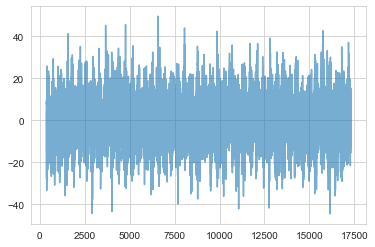

In [8]:
plt.plot(df_diff1, alpha = .6)
#plt.plot(df_diff2, alpha = 0.3)

In [9]:
# check if everything worked
df_diff2.tail()
print(df_diff1.isna().sum().sum()) 

366


#### CHECK THE AUTOCORRELATIONS OF DIFF1 AND DIFF2

In [10]:
## Bring back functions from notebook 2


def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature+"_lag"] = np.nan
    
    lag_df.loc[lag:,feature+"_lag"] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    
    return lag_df


def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature+"_lag"].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

First get the autocorrelations for temperature data, with daily lag

In [11]:
s = 1
n = 365
# this stores the autocorrelations for the 
# temp data
df_autos = []
for i in range(s,n*s,s):
    df_autos.append(get_autocorr(df,'temp',i))

In [12]:
df_autos

[0.9446363657190298,
 0.8884930651781641,
 0.864474374316449,
 0.8528042398738856,
 0.8463038522407748,
 0.841678936822395,
 0.836447838216315,
 0.8318323758811778,
 0.8278364596937521,
 0.8229422208059034,
 0.8180174563814505,
 0.8141232637737037,
 0.8106211261466643,
 0.8073663777346589,
 0.8042433849563837,
 0.8005643246475628,
 0.7968009279115751,
 0.7928226431306232,
 0.788043452969609,
 0.7848663284001812,
 0.7813079531487608,
 0.7756176084263822,
 0.7692318063082897,
 0.7626106857038291,
 0.7561270441381148,
 0.7502780716189212,
 0.7431884871317034,
 0.7360169623273785,
 0.7286966945340573,
 0.7194770240898993,
 0.7102680912870664,
 0.7016623002630222,
 0.694090287711879,
 0.6881340867146538,
 0.6811238019275012,
 0.6733423497690335,
 0.6645028070731787,
 0.6549756124643915,
 0.6453689776253692,
 0.6362390472793056,
 0.6279533511304352,
 0.6197555992139128,
 0.6107717768493552,
 0.6010415290555401,
 0.5907600028929639,
 0.579602284413634,
 0.5686443506281126,
 0.5591129864090948

In [13]:
diff_df = df.diff(periods = 365).dropna().reset_index(drop=True)

In [14]:
diff_df.head()

,year,mo,da,temp,dewp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,date
0,1.0,0.0,0.0,-21.4,-12.4,-7.3,-3.4,0.13,1.0,0.0,0.0,0.0,0.0,0.0,365 days
1,1.0,0.0,0.0,-9.6,-9.0,0.2,-0.4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,365 days
2,1.0,0.0,0.0,0.2,1.8,-6.2,-2.3,0.01,1.0,1.0,1.0,0.0,0.0,0.0,365 days
3,1.0,0.0,0.0,-10.0,-9.4,-1.4,0.6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,365 days
4,1.0,0.0,0.0,-13.8,-12.0,-2.3,-4.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,365 days


In [15]:
df_diff_autos = []

for i in range(s,n*s,s):
    df_diff_autos.append(get_autocorr(diff_df,'temp',i))

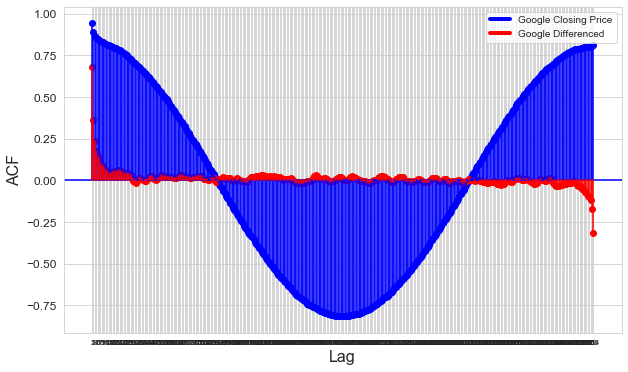

In [16]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]


# make a figure
plt.figure(figsize=(10,6))

# plot a horizontal line
plt.axhline(y=0, xmin=0, xmax=n, color = "blue")

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           df_autos,
           c='b')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,df_autos[i-1]],'b')

# Add labels
plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

## plot ACFs of differenced data

# set tick marks
plt.xticks(np.arange(1,n,1), fontsize=8)
plt.yticks(fontsize=12)

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           df_diff_autos,
           c='r')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,df_diff_autos[i-1]],'r')
    
plt.legend(custom_lines, ['Google Closing Price', 'Google Differenced'])

plt.show()

In [17]:
# ACF and PACF plots here
# smg.tsaplots.plot_acf(df_diff1,lags = np.arange(365,365*46,365))

NameError: name 'smg' is not defined

First, clean nans that were created during differencing

In [ ]:
# Clean nans
df_diff2_nans = df_diff2.isna() # store nans just in case
df_cleaned = df_diff2.dropna()
df_cleaned.head()

### Train/test splits

In [18]:
QUARANTINE = '2020-04-01'
train_cleaned = diff_df[diff_df.date <= QUARANTINE].copy()
test_cleaned = diff_df[diff_df.date > QUARANTINE].copy()

TypeError: Invalid comparison between dtype=timedelta64[ns] and str

In [ ]:
import statsmodels.api as sm
import statsmodels.graphics as smg


In [ ]:
plt.plot(train_cleaned)
plt.plot(test_cleaned)

In [ ]:
# Import the ARIMA object
from statsmodels.tsa.api import ARIMA

In [ ]:
# First put in the training values
# then enter the order as (p,d,q)

arima = ARIMA(train_cleaned.values, order = (1,2,1)) # d = 2, because our data is seasonal

In [ ]:
# Fit the model
arima_fit = arima.fit()

In [ ]:
# plot the forecast
plt.figure(figsize=(10,6))

# the training data and fitted values
plt.plot(train_cleaned.index, train_cleaned,
             'b', label = "Training Data")
plt.plot(train_cleaned.index, arima_fit.fittedvalues,
             'r', label = "Fitted Values")
plt.plot(test_cleaned.index, test_cleaned, 
             'b', alpha = 0.4, label = "Test Data")
plt.plot(test_cleaned.index, arima_fit.forecast(len(test_cleaned))[0],
             'r--', label = "Forecast")
plt.xlim(datetime.date(2018, 1, 1),
        datetime.date(2021, 1, 1))

plt.xlabel("Year (days)", fontsize = 16)
plt.ylabel("Temperature diff(t-366)", fontsize = 16)

plt.legend(fontsize=14)

plt.show()